**Import Libraries:**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Read in csv file as a DataFrame
#test dataset
te_df = pd.read_csv("test.csv")

#train dataset
tr_df = pd.read_csv("loan-train.csv")

In [7]:
# Explore the first 5 rows
te_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [8]:
# Explore the first 5 rows
tr_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [9]:
# Column information
tr_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
# Drop the 'Loan_ID' column for both test and train datasets
tr_df.drop('Loan_ID', axis=1, inplace=True)
te_df.drop('Loan_ID', axis=1, inplace=True)

# Checking the new shapes
print(f"training set (row, col): {tr_df.shape}\n\ntesting set (row, col): {te_df.shape}")

training set (row, col): (614, 12)

testing set (row, col): (367, 11)


In [11]:
# Missing values in descending order
tr_df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
# Handling missing values
null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount', 'Dependents', 'Loan_Amount_Term', 'Gender', 'Married']
for col in null_cols:
    tr_df[col].fillna(tr_df[col].mode().values[0], inplace=True)

# Explore missing values after filling
print("After filling missing values:","\n")
print(tr_df.isnull().sum().sort_values(ascending=False))

After filling missing values: 

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [13]:
# Numeric and Categorical columns
num = tr_df.select_dtypes('number').columns.to_list()
cat = tr_df.select_dtypes('object').columns.to_list()

# Convert categorical values to numbers
to_numeric = {'Male': 1, 'Female': 2, 'Yes': 1, 'No': 2, 'Graduate': 1, 'Not Graduate': 2, 'Urban': 3, 'Semiurban': 2,
              'Rural': 1, 'Y': 1, 'N': 0, '3+': 3}
tr_df = tr_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)

# Convert 'Dependents' column to numeric
tr_df['Dependents'] = pd.to_numeric(tr_df['Dependents'])

# Checking the manipulated dataset for validation
print(f"training set (row, col): {tr_df.shape}\n")
print(tr_df.info())

training set (row, col): (614, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
None


In [14]:
# Get value counts for all variables
for column in tr_df.columns:
    print(f"\nValue counts for {column}:\n{tr_df[column].value_counts()}\n{'-'*50}")


Value counts for Gender:
1    502
2    112
Name: Gender, dtype: int64
--------------------------------------------------

Value counts for Married:
1    401
2    213
Name: Married, dtype: int64
--------------------------------------------------

Value counts for Dependents:
0    360
1    102
2    101
3     51
Name: Dependents, dtype: int64
--------------------------------------------------

Value counts for Education:
1    480
2    134
Name: Education, dtype: int64
--------------------------------------------------

Value counts for Self_Employed:
2    532
1     82
Name: Self_Employed, dtype: int64
--------------------------------------------------

Value counts for ApplicantIncome:
2500    9
4583    6
6000    6
2600    6
3333    5
       ..
3244    1
4408    1
3917    1
3992    1
7583    1
Name: ApplicantIncome, Length: 505, dtype: int64
--------------------------------------------------

Value counts for CoapplicantIncome:
0.0       273
2500.0      5
2083.0      5
1666.0      5
2250

**Data Visualization:**

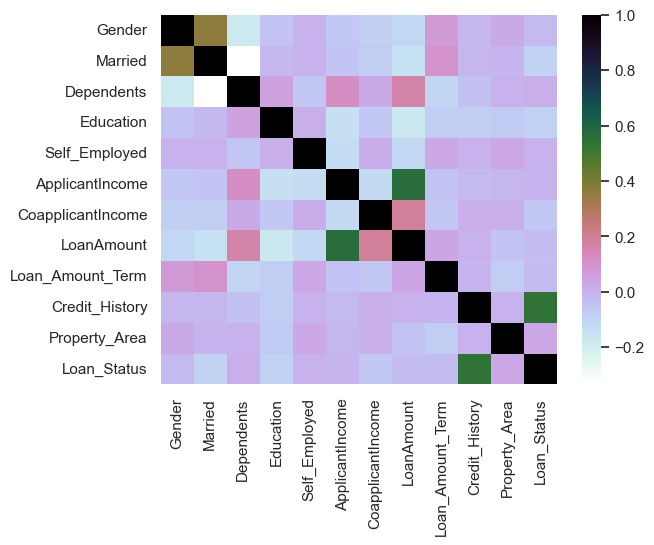

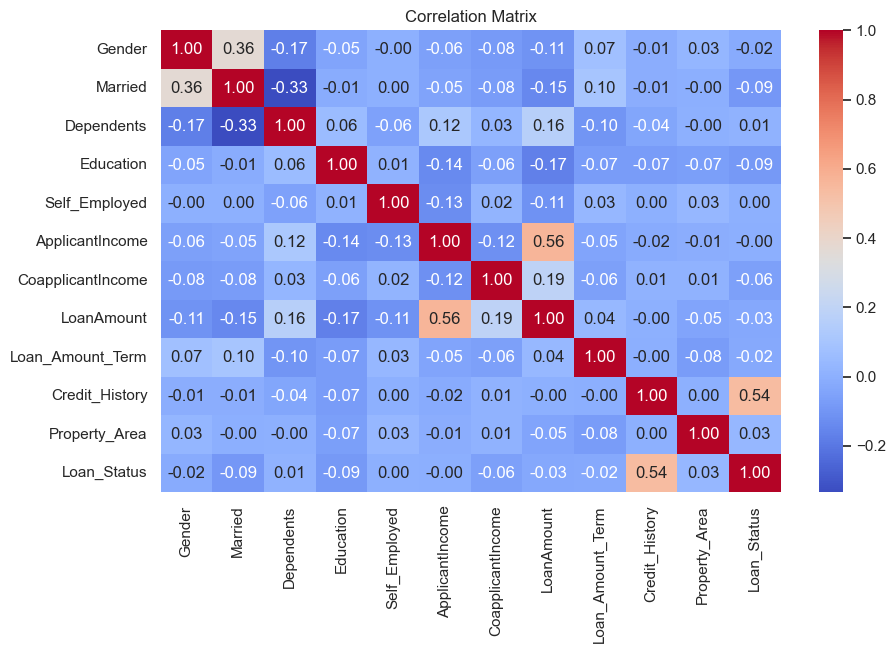

In [15]:
#plotting the correlation matrix
sns.heatmap(tr_df.corr() ,cmap='cubehelix_r')

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(tr_df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

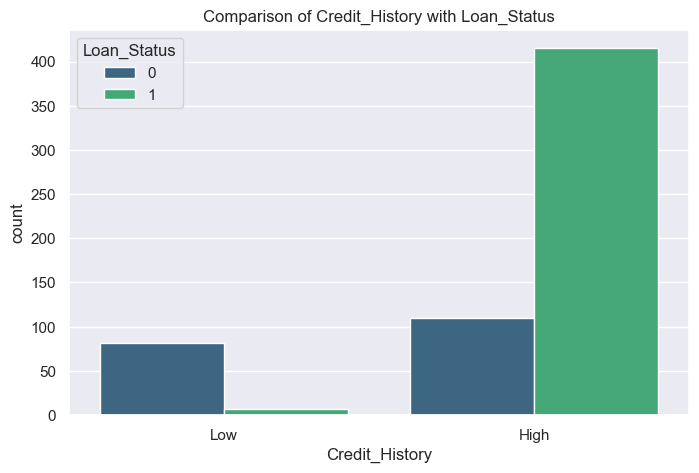

In [16]:
# Compare Credit_History with Loan_Status using sns graph
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Credit_History', hue='Loan_Status', data=tr_df, palette='viridis')
# Set x-axis labels
ax.set_xticklabels(['Low', 'High'])
plt.title('Comparison of Credit_History with Loan_Status')
plt.show()

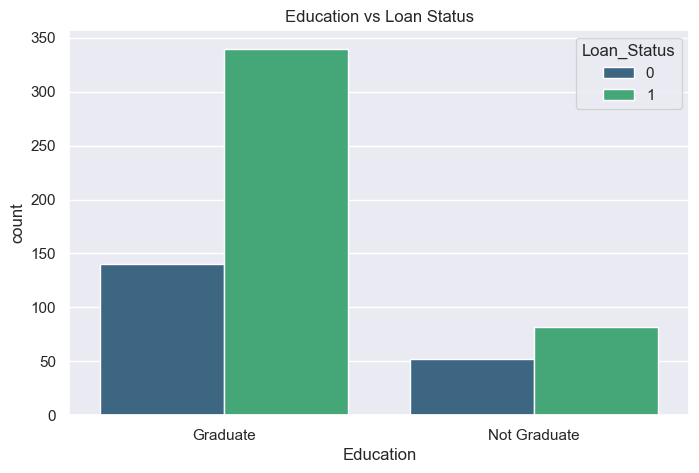

In [17]:
# Countplot for Education vs Loan_Status
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Education', hue='Loan_Status', data=tr_df, palette='viridis')
# Set x-axis labels
ax.set_xticklabels(['Graduate', 'Not Graduate'])
plt.title('Education vs Loan Status')
plt.show()

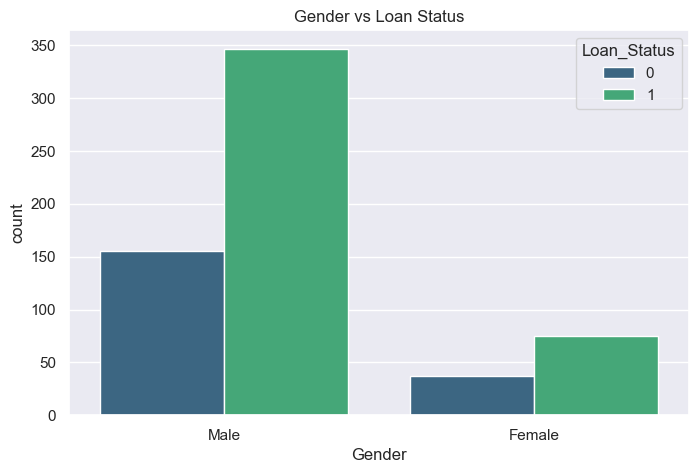

In [18]:
# Countplot for Gender vs Loan_Status
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Gender', hue='Loan_Status', data=tr_df, palette='viridis')
# Set x-axis labels
ax.set_xticklabels(['Male', 'Female'])
plt.title('Gender vs Loan Status')
plt.show()

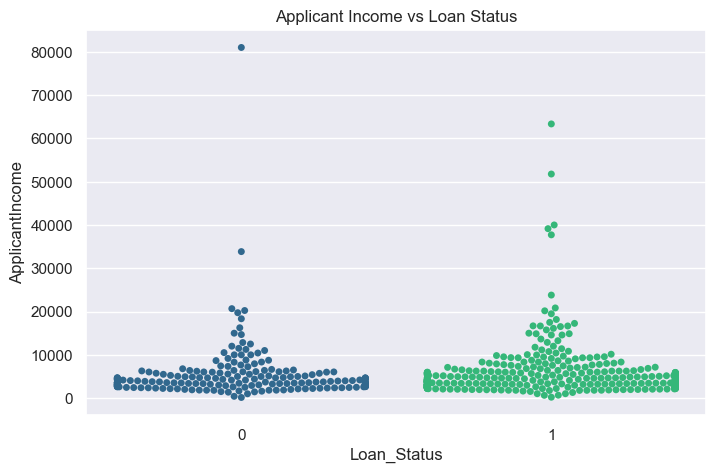

In [19]:
# Swarm plot for ApplicantIncome vs Loan_Status
plt.figure(figsize=(8, 5))
sns.swarmplot(x='Loan_Status', y='ApplicantIncome', data=tr_df, palette='viridis')
plt.title('Applicant Income vs Loan Status')
plt.show()

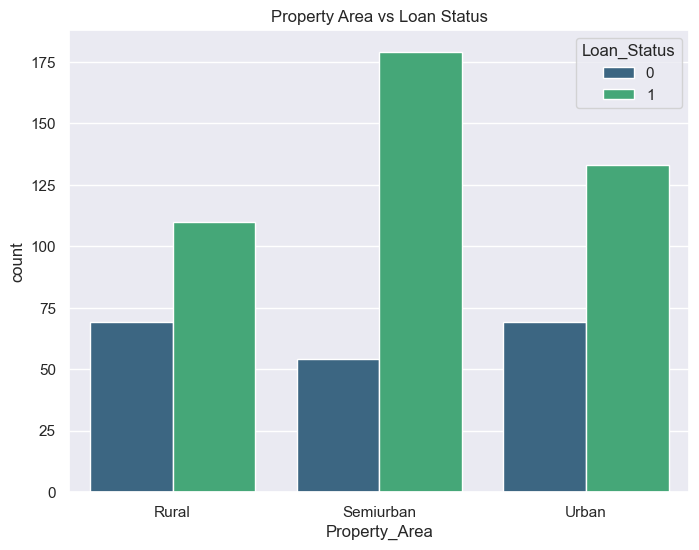

In [20]:
# Countplot for Property_Area vs Loan_Status
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Property_Area', hue='Loan_Status', data=tr_df, palette='viridis')
# Set x-axis labels
ax.set_xticklabels(['Rural', 'Semiurban', 'Urban'])
plt.title('Property Area vs Loan Status')
plt.show()

In [21]:
# Models
X = tr_df.drop('Loan_Status', axis=1)
y = tr_df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
# Decision Tree
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_predict = DT.predict(X_test)

# Prediction Summary by Loan Status
print(classification_report(y_test, y_predict))
DT_SC = accuracy_score(y_predict, y_test)
print(f"Accuracy is {round(DT_SC * 100, 2)}%")

Decision_Tree = pd.DataFrame({'y_test': y_test, 'prediction': y_predict})
Decision_Tree.to_csv("Decision Tree.csv")

              precision    recall  f1-score   support

           0       0.47      0.53      0.50        51
           1       0.81      0.77      0.79       134

    accuracy                           0.70       185
   macro avg       0.64      0.65      0.64       185
weighted avg       0.72      0.70      0.71       185

Accuracy is 70.27%


In [23]:
# Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_predict = RF.predict(X_test)
print(classification_report(y_test, y_predict))
RF_SC = accuracy_score(y_predict, y_test)
print(f"Accuracy is {round(RF_SC * 100, 2)}% Accurate")

Random_Forest = pd.DataFrame({'y_test': y_test, 'prediction': y_predict})
Random_Forest.to_csv("Random Forest.csv")


              precision    recall  f1-score   support

           0       0.71      0.43      0.54        51
           1       0.81      0.93      0.87       134

    accuracy                           0.79       185
   macro avg       0.76      0.68      0.70       185
weighted avg       0.78      0.79      0.78       185

Accuracy is 79.46% Accurate


In [24]:
# XGBoost
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
y_predict = XGB.predict(X_test)
print(classification_report(y_test, y_predict))
XGB_SC = accuracy_score(y_predict, y_test)
print(f"{round(XGB_SC * 100, 2)}% Accurate")

XGBoost = pd.DataFrame({'y_test': y_test, 'prediction': y_predict})
XGBoost.to_csv("XGBoost.csv")

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        51
           1       0.84      0.91      0.87       134

    accuracy                           0.81       185
   macro avg       0.76      0.72      0.74       185
weighted avg       0.80      0.81      0.80       185

80.54% Accurate


In [25]:
# Logistic Regression
LR = LogisticRegression()
LR.fit(X_train, y_train)
y_predict = LR.predict(X_test)
print(classification_report(y_test, y_predict))
LR_SC = accuracy_score(y_predict, y_test)
print(f"Accuracy is {round(LR_SC * 100, 2)}%")

Logistic_Regression = pd.DataFrame({'y_test': y_test, 'prediction': y_predict})
Logistic_Regression.to_csv("Logistic Regression.csv")

              precision    recall  f1-score   support

           0       0.92      0.43      0.59        51
           1       0.82      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.87      0.71      0.74       185
weighted avg       0.85      0.83      0.81       185

Accuracy is 83.24%


In [26]:
# Support Vector Machine (SVM)
SVM = SVC()
SVM.fit(X_train, y_train)
y_predict = SVM.predict(X_test)
print(classification_report(y_test, y_predict))
SVM_SC = accuracy_score(y_predict, y_test)
print(f"Accuracy is {round(SVM_SC * 100, 2)}%")

Support_Vector_Machine = pd.DataFrame({'y_test': y_test, 'prediction': y_predict})
Support_Vector_Machine.to_csv("Support Vector Machine.csv")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.72      1.00      0.84       134

    accuracy                           0.72       185
   macro avg       0.36      0.50      0.42       185
weighted avg       0.52      0.72      0.61       185

Accuracy is 72.43%


In [27]:
# Naive Bayes
NB = GaussianNB()
NB.fit(X_train, y_train)
y_predict = NB.predict(X_test)
print(classification_report(y_test, y_predict))
NB_SC = accuracy_score(y_predict, y_test)
print(f"Accuracy is {round(NB_SC * 100, 2)}%")

# Save predictions to CSV
Naive_Bayes = pd.DataFrame({'y_test': y_test, 'prediction': y_predict})
Naive_Bayes.to_csv("Naive Bayes.csv")

              precision    recall  f1-score   support

           0       0.85      0.43      0.57        51
           1       0.82      0.97      0.89       134

    accuracy                           0.82       185
   macro avg       0.83      0.70      0.73       185
weighted avg       0.83      0.82      0.80       185

Accuracy is 82.16%


In [29]:
# Display the contents of each DataFrame
print("Decision Tree:")
print(Decision_Tree)

print("\nRandom Forest:")
print(Random_Forest)

print("\nXGBoost:")
print(XGBoost)

print("\nLogistic Regression:")
print(Logistic_Regression)

print("\nSupport Vector Machine:")
print(Support_Vector_Machine)

print("\nNaive Bayes:")
print(Naive_Bayes)

Decision Tree:
     y_test  prediction
454       1           0
52        0           1
536       1           1
469       0           0
55        1           1
..      ...         ...
242       1           0
515       1           1
582       1           1
225       0           1
134       1           1

[185 rows x 2 columns]

Random Forest:
     y_test  prediction
454       1           1
52        0           1
536       1           1
469       0           1
55        1           1
..      ...         ...
242       1           0
515       1           1
582       1           1
225       0           1
134       1           1

[185 rows x 2 columns]

XGBoost:
     y_test  prediction
454       1           0
52        0           1
536       1           1
469       0           0
55        1           1
..      ...         ...
242       1           1
515       1           1
582       1           1
225       0           1
134       1           1

[185 rows x 2 columns]

Logistic Regression:
 

**Result:**

In [30]:
# Comparing model performance
score = [DT_SC, RF_SC, XGB_SC, LR_SC, SVM_SC, NB_SC]
Models = pd.DataFrame({
    'Model': ["Decision Tree", "Random Forest", "XGBoost", "Logistic Regression", "Support Vector Machine","Naive Bayes"],
    'Score': score
})
Models.sort_values(by='Score', ascending=False)

,Model,Score
3,Logistic Regression,0.832432
5,Naive Bayes,0.821622
2,XGBoost,0.805405
1,Random Forest,0.794595
4,Support Vector Machine,0.724324
0,Decision Tree,0.702703


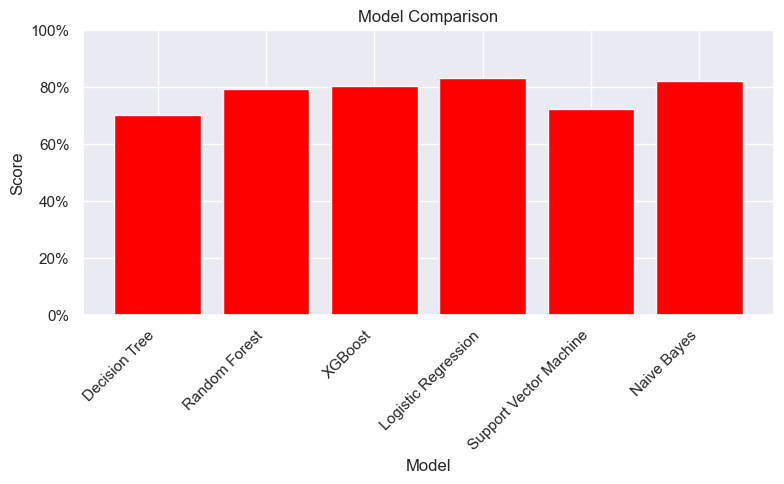

In [31]:
from matplotlib.ticker import FuncFormatter
def percentage_formatter(x, pos):
    return f'{x*100:.0f}%'
plt.figure(figsize=(8, 5))
plt.bar(Models['Model'], Models['Score'], color='red')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(rotation=45, ha='right')
# Set the y-axis limits to show percentages from 0% to 100%
plt.ylim(0, 1)
# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.tight_layout()
plt.show()

**Conclusion:**

**Feature Importance:**

The analysis highlighted Credit_History as a critical variable, showing a substantial correlation with Loan_Status. Recognizing the significance of Credit_History is crucial, given its considerable impact on loan approval outcomes.

**Model Performance:**

In the evaluation of machine learning models for loan prediction, Logistic Regression emerged as the top-performing model with an accuracy of approximately 83.24%.

The models, ranked by accuracy, are as follows:

Logistic Regression (83.24%)
Naive Bayes (82.16%)
XGBoost (80.54%)
Random Forest (80.00%)
Support Vector Machine (72.43%)
Decision Tree (71.35%)

Logistic Regression and Naive Bayes demonstrated competitive performance, indicating their suitability for this task. The choice between these top-performing models should consider additional factors such as interpretability, computational efficiency, and the specific requirements of the application.